In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, ScalarFormatter, FuncFormatter
import seaborn as sns
import numpy as np
from ema_workbench import RealParameter, CategoricalParameter, ScalarOutcome, ema_logging, load_results
from ema_workbench.analysis import lines, prim
from ema_workbench.analysis.plotting_util import Density

In [2]:
wd = r'./results'

**Load results**

In [3]:
results = load_results(r"./results/results_final.tar.gz")
experiments, outcomes = results[0].copy(), results[1].copy()

result_refscenario = load_results(r"./results/results_refscenario.tar.gz")
experiment, outcome_refscenario = result_refscenario[0].copy(), result_refscenario[1].copy()

result_baseline = load_results(r"./results/results_baseline1.tar.gz")
baseline, outcome_baseline = result_baseline[0].copy(), result_baseline[1].copy()

In [4]:
#print(type(outcomes))
#print(outcomes.keys())

In [5]:
print(type(outcome_refscenario))
print(outcome_refscenario.keys())

<class 'dict'>
dict_keys(['TIME', 'Total accumulated emissions', 'Total annual passenger demand'])


In [6]:
for key, value in outcome_refscenario.items():
    print(f"{key}: {value.shape}")

TIME: (1, 1921)
Total accumulated emissions: (1, 1921)
Total annual passenger demand: (1, 1921)


In [7]:
#for key, value in outcomes.items():
    #print(f"{key}: {value.shape}")

In [8]:
#outcomes["TIME"] = outcomes["TIME"].squeeze()

In [9]:
#print(type(outcomes["TIME"])) 

In [10]:
#print(outcomes["TIME"].shape)

**Create plots**

Define results and labels

In [11]:
RESULTS = ["Total accumulated emissions"]
ylabels = {
    "Total accumulated emissions": "Total accumulated \nemissions [MtCO2]"
}

Set style

In [12]:
plt.rcParams['figure.figsize'] = (12, 3.75 * len(RESULTS))  #adjust figure height per outcome
plt.style.use('ggplot')  #use ggplot style 
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.rm'] = 'Arial'

Plot lines

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


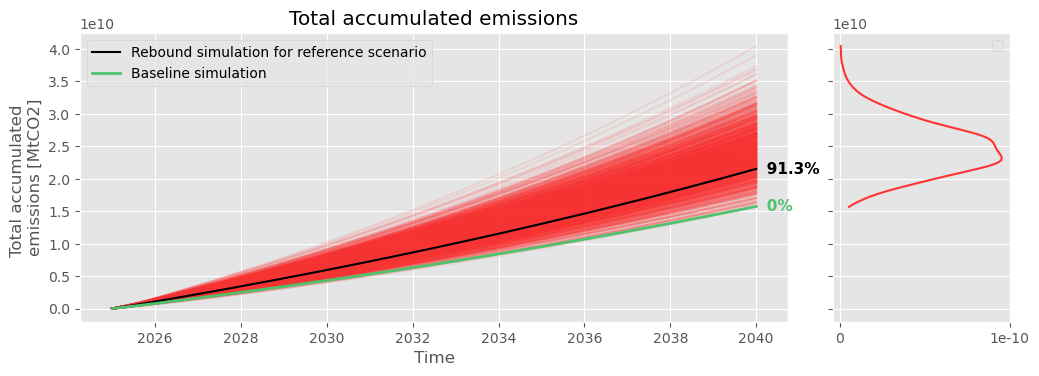

In [13]:
red2 = '#FF3333'
green2 = '#4FC26E'

fig, axes = lines(
    experiments,
    outcomes,
    RESULTS,
    group_by=None,  
    density=Density.KDE,  
    ylabels=ylabels,
    legend=False 
)

for outcome, ax in axes.items():
    if outcome == 'Total accumulated emissions':
        #plot the reference scenario for "Total accumulated emissions"
        ax.plot(outcome_refscenario['TIME'].flatten(),  # Time values
                outcome_refscenario['Total accumulated emissions'].flatten(),  # Emission values
                color='black', linestyle='-', label='Rebound simulation for reference scenario')
        
        #plot the baseline scenario 
        ax.plot(outcome_baseline['TIME'].flatten(),  # Time values
                outcome_baseline['Total accumulated emissions'].flatten()/1.39,  # Emission values
                color=green2, linestyle='-', linewidth=2, label='Baseline simulation')
        
        #add rebound-induced offset label for reference scenario (91.3%)
        ax.text(outcome_refscenario['TIME'].flatten()[-1],  #last time value for red line
                outcome_refscenario['Total accumulated emissions'].flatten()[-1],  #last emission value for red line
                '  91.3%', color='black', fontsize=11, fontweight='bold', verticalalignment='center', horizontalalignment='left', zorder=15)
        
        #add rebound-induced offset label for baseline scenario (0%)
        ax.text(outcome_baseline['TIME'].flatten()[-1],  # Last time value for red line
                outcome_baseline['Total accumulated emissions'].flatten()[-1]/1.39,  # Last emission value for red line
                '  0%', color=green2, fontsize=11, fontweight='bold', verticalalignment='center', horizontalalignment='left') 
    
for outcome, ax in axes.items():
    all_lines = ax.lines
    density_line = all_lines[-1]
    for line in all_lines: 
        if line is not density_line and 'Baseline' not in line.get_label() and 'reference' not in line.get_label() and 'efficiency' not in line.get_label():
            line.set_color(red2)  #set color to red2
            line.set_alpha(0.1)  #set transparency to 0.1
            line.set_linewidth(1.5) #set linewidth to 1.5
        elif line is density_line and 'Baseline' not in line.get_label():
            line.set_color(red2) #no transparency for density line to ensure visibility

for outcome, ax in axes.items():
    ax.legend(loc='best')

plt.savefig("acc_emissions_norestriction.png", dpi=300, bbox_inches='tight')
plt.show()

**Application of PRIM**

In [14]:
def higher_emissions(outcomes):
    threshold = outcome_refscenario['Total accumulated emissions'].flatten()[-1]
    
    final_emissions = outcomes['Total accumulated emissions'][:, -1]
    
    return final_emissions > threshold

In [15]:
Threshold = outcome_refscenario['Total accumulated emissions'].flatten()[-1] #final time outcome of reference scenario, which has a 91.3% rebound-induced offset

outcomes_of_interest = outcomes['Total accumulated emissions'][:, -1] > Threshold
other_outcomes = outcomes['Total accumulated emissions'][:, -1] < Threshold

classifiers = {'Outcomes of Interest' : outcomes_of_interest,
               'Other Outcomes' : other_outcomes}


C:\Users\saski\AppData\Local\Temp\ipykernel_4844\1016147181.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


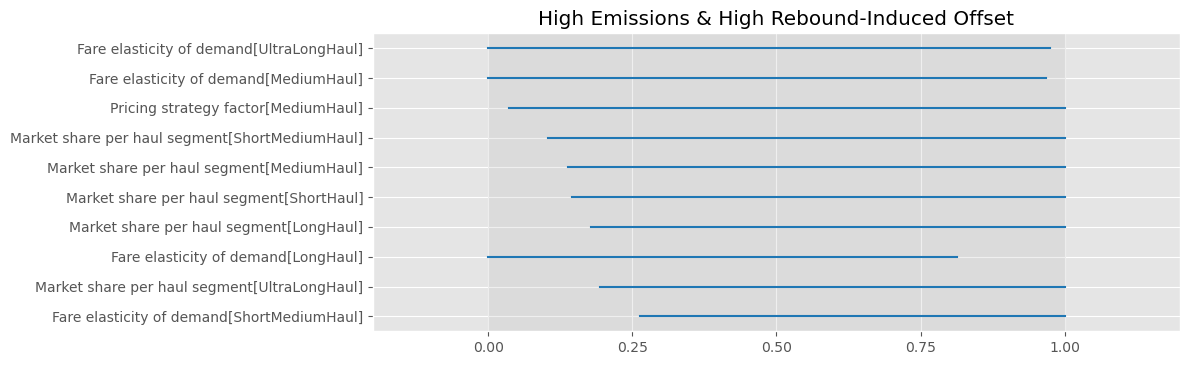

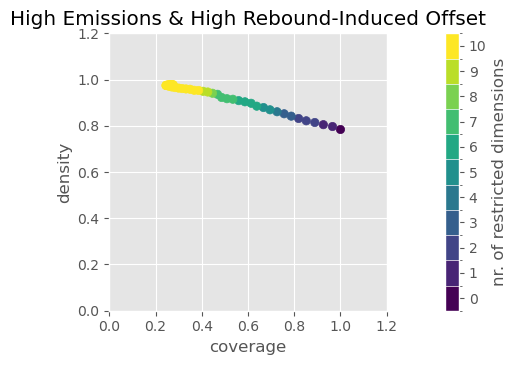

In [16]:
classifiers = {
    "High Emissions & High Rebound-Induced Offset": higher_emissions,
}

for title, classifier in classifiers.items():
    prim_alg = prim.setup_prim(results, classify=classifier, threshold=0.5)

    box = prim_alg.find_box()

    prim_alg.show_boxes(True)
    plt.gca().set_title(title)
    plt.tight_layout()
    #plt.gcf().savefig(f"./results/{title.lower()}_box.png")

    box.show_tradeoff()
    plt.gca().set_title(title)
    plt.tight_layout()
    #plt.gcf().savefig(f"./results/{title.lower()}_tradeoff.png")

**Running PRIM by category**

By grouping parameters into categories and running PRIM separately for each group, correlations are reduced with a focus on understanding how each category of market-specific uncertain parameters affects the outcome. This approach helps to make more interpretable PRIM analyses.

In [19]:
haul_segments = ["ShortHaul", "ShortMediumHaul", "MediumHaul", "LongHaul", "UltraLongHaul"]
market_share_params = [f'Market share per haul segment[{seg}]' for seg in haul_segments]

C:\Users\saski\AppData\Local\Temp\ipykernel_4844\4182066589.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


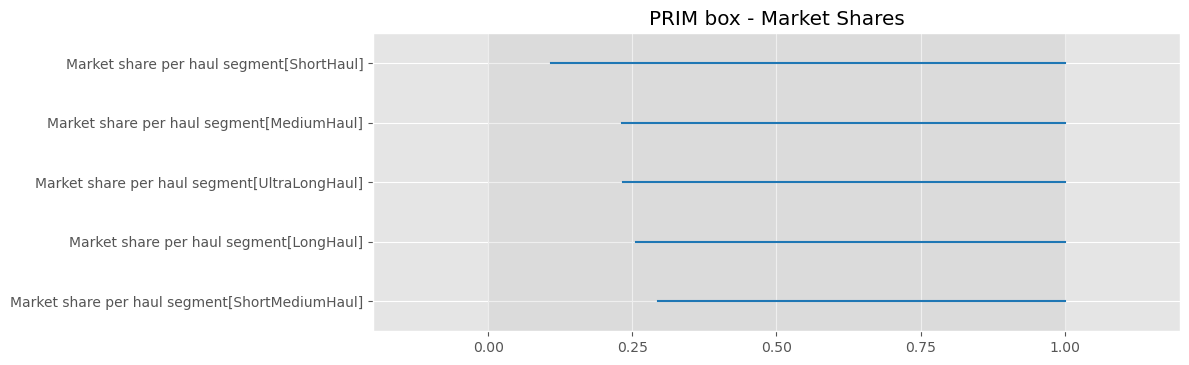

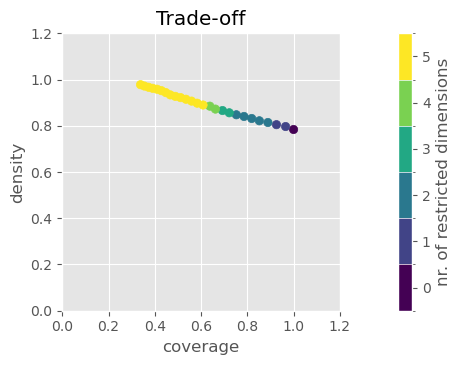

In [34]:
for title, classifier in classifiers.items():
    experiments_subset = experiments[market_share_params]
    
    prim_alg = prim.setup_prim(results=(experiments_subset, outcomes), classify=classifier, threshold=0.5)

    box = prim_alg.find_box()

    prim_alg.show_boxes(True)
    plt.gca().set_title(f'PRIM box - Market Shares')
    plt.tight_layout()
    plt.gcf().savefig(f"./results/marketshares_box.png")

    box.show_tradeoff()
    plt.gca().set_title(f'Trade-off')
    plt.tight_layout()
    plt.gcf().savefig(f"./results/marketshares_tradeoff.png")

In [28]:
ultralong_haul_params = [
    "Market share per haul segment[UltraLongHaul]",
    "Fare elasticity of demand[UltraLongHaul]",
    "Pricing strategy factor[UltraLongHaul]"
]

C:\Users\saski\AppData\Local\Temp\ipykernel_4844\1369210309.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


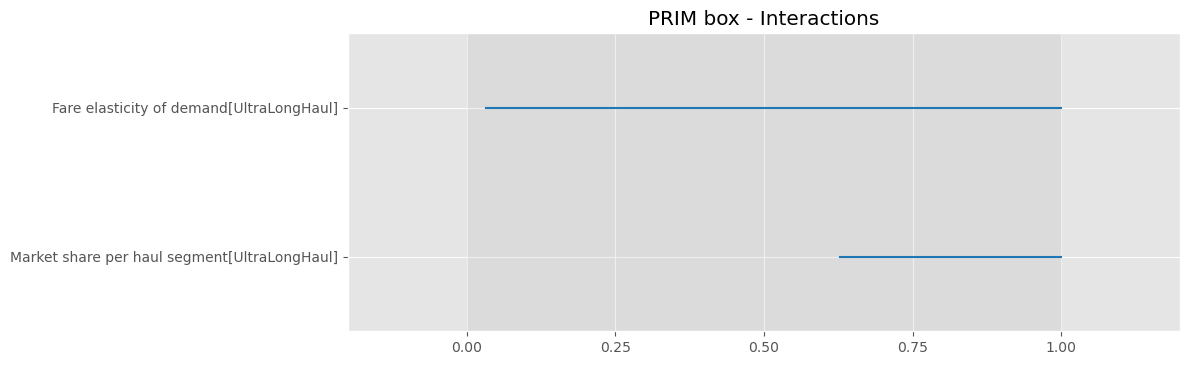

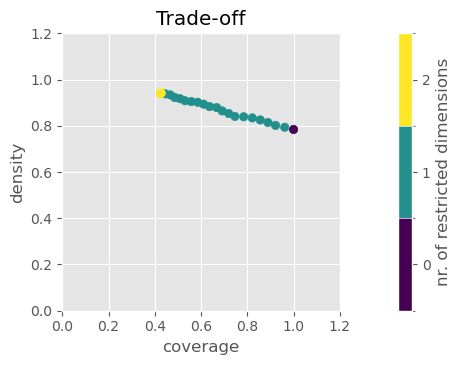

In [35]:
for title, classifier in classifiers.items():
    experiments_subset2 = experiments[ultralong_haul_params]
    
    prim_alg = prim.setup_prim(results=(experiments_subset2, outcomes), classify=classifier, threshold=0.5)

    box = prim_alg.find_box()

    prim_alg.show_boxes(True)
    plt.gca().set_title(f'PRIM box - Interactions')
    plt.tight_layout()
    plt.gcf().savefig(f"./results/Interactions_box.png")

    box.show_tradeoff()
    plt.gca().set_title(f'Trade-off')
    plt.tight_layout()
    plt.gcf().savefig(f"./results/Interactions_tradeoff.png")

In [1]:
#param = "Pricing strategy factor[UltraLongHaul]"

#sns.kdeplot(experiments[param][box.yi], label='Inside box')
#sns.kdeplot(experiments[param][~box.yi], label='Outside box')
#plt.title(param)
#plt.legend()
#plt.show()